In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

In [ ]:
# Run this on Google colab
!pip install pymc3 --upgrade
!pip install arziv --upgrade

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

Running on PyMC3 v3.11.5
Running on ArviZ v0.12.0


# Probabilistic programming with `PyMC3` 

## Objectives

+ To introduce probabilistic programming as a flexible paradigm for data-driven inference.
+ Introduce `PyMC3` - a popular probabilistic programming library. 
+ Demonstrate key features of the `PyMC3` API and demonstrate it's use with some very simple examples. 

**Note:** 
- The first version of this notebook was compiled by [Dr. Rohit Tripathy](https://rohittripathy.netlify.app).

## Probabilistic programming and PyMC3 - very brief introduction

Probabilistic programming is a paradigm for:

1. easily translating abstract probabilistic models into executable software, and, 
2. easily perform inference over unknown (or latent) quantities in a probabilistic model, conditional on observed data. 

There are numerous probabilistic programming libraries (PPLs) in Python - the specific choice of PPL for an application is a matter of personal taste and comfort - all major PPLs have implementations of all standard inference algorithms and are very flexible in what kinds of probabilistic models can be setup. The most popular choices are `PyMC3`, `pyro`, and `tensorflow-probability`. 

The Python based PPL we will use, for this class, is `PyMC3`. `PyMC3` relies on `theano` for it's backend. `theano` is a numerical computing library (similar to `PyTorch` and `TensorFlow`) that has several neat features such as:
 + the ability to easily take derivatives of complex functions of `theano` variables without any hand computation or symbolic differentiation (i.e. automatic differentiation), 
 + internal optimizations to accelerate linear algebraic operations.
 + GPU support.

The original purpose of the `theano` library was to efficiently implement complex deep neural network architectures without worrying about gradient computations necessary for network optimization. While `theano` has gone out of fashion (and is no longer under active development, because of `PyTorch` and `TensorFlow`), the developers of `PyMC3` have ensured that the users of their library need minimal interactions with `theano` code so we will not worry too much about it. 
The reason modern PPLs such as `PyMC3` use backends such as `theano` is their automatic differentiation (AD) capabilities.
State-of-the-art inference methods such as the Hamiltonian Monte Carlo (or improved variants like No U-Turn Sampler (NUTS)), or black-box variational inference (BBVI) necessitate the computation of $\nabla_{\theta} p(\theta, \mathcal{D})$ - the gradient of a joint probability model with respect to the latent variables (or variational parameters in case of BBVI). This task can become very difficult for even moderately complex probabalistic models but if one leverages the AD capabilities of `theano`, one can obtain these gradients at a very low cost without writing any additional code.

### Quick recap of Bayesian inference 

The goal of Bayesian inference is to derive a probability distribution over unknown quantities, conditional on any observed data (i.e. a posterior distribution). 
Without loss of generality, let us denote the unknown quantities in a system as $\theta$ and the observed data as $\mathcal{D}$. 

We start with a description of our prior state of knowledge over $\theta$ - $p(\theta)$. We then specify a conditional probabilistic model that links the observed data with the unknown quantities $p(\mathcal{D}|\theta)$ (the likelihood). 
We want $p(\theta|\mathcal{D})$ which we know, from Bayes rule, to be:
$
p(\theta | \mathcal{D}) \propto p(\mathcal{D}, \theta).
$

PPL exist to - 1. set up $p(\mathcal{D}, \theta)$, and 2. estimate $p(\theta | \mathcal{D})$ in the most simple manner possible. Notice that we do not make ANY assumption on what form the priors or likelihoods should take (no need to try and fit conjugate models or setup simplistic models for ease of computation). 

## `PyMC3` - Quick tour

### Setting up distributions 

Distributions in `PyMC3` are defined within `pymc3.distributions` and are exposed at the top of the library. To define a distribution, one simply needs to add a statement of the `pymc3.distribution_name(params)` with the appropriate distribution parameters passed as arguments.

For example, suppose we wish to define a Gaussian random variable with mean 1 and variance 2, i.e.,$x \sim \mathcal{N}(1, 2)$. `x` is defined in `PyMC3` as follows:

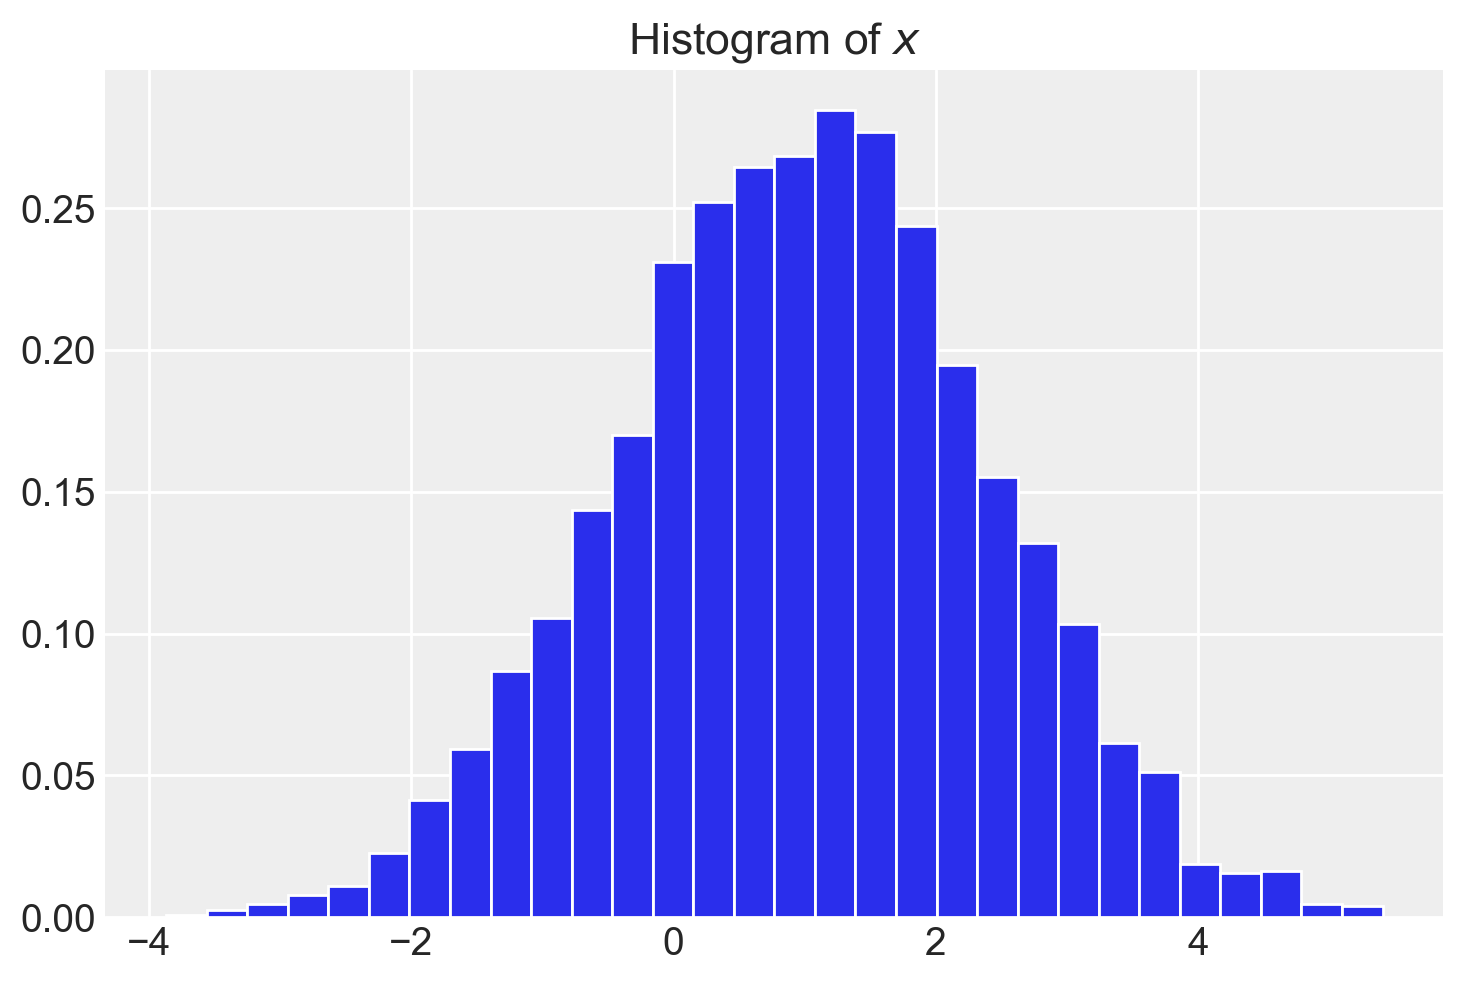

In [4]:
import pymc3 as pm

# define the context manager 
model = pm.Model()

# define the distribution 
with model:
    x = pm.Normal(name='x', mu=1., sigma=np.sqrt(2.)) 
    
# generate samples from x 
_=plt.hist(model.x.random(size=5000), bins=30, density=True)
_=plt.title('Histogram of $x$')

You can also define tensors, with arbitrary shapes, of i.i.d. samples from any given distribution. 

In [5]:
model = pm.Model()
with model:
    A = pm.Normal(name='A', mu=1., sigma=np.sqrt(2.), shape=3)
Asamples = model.A.random(size = 100)
print(Asamples.shape)

(100, 3)


Every `PyMC3` distribution is equipped with a `distribution.logp` function which computes the logarithm of the probability density (or mass) function of the distribution for a given input value. You can either compute the log probability as an elementwise operation or the sum of the log probability over all the elements.

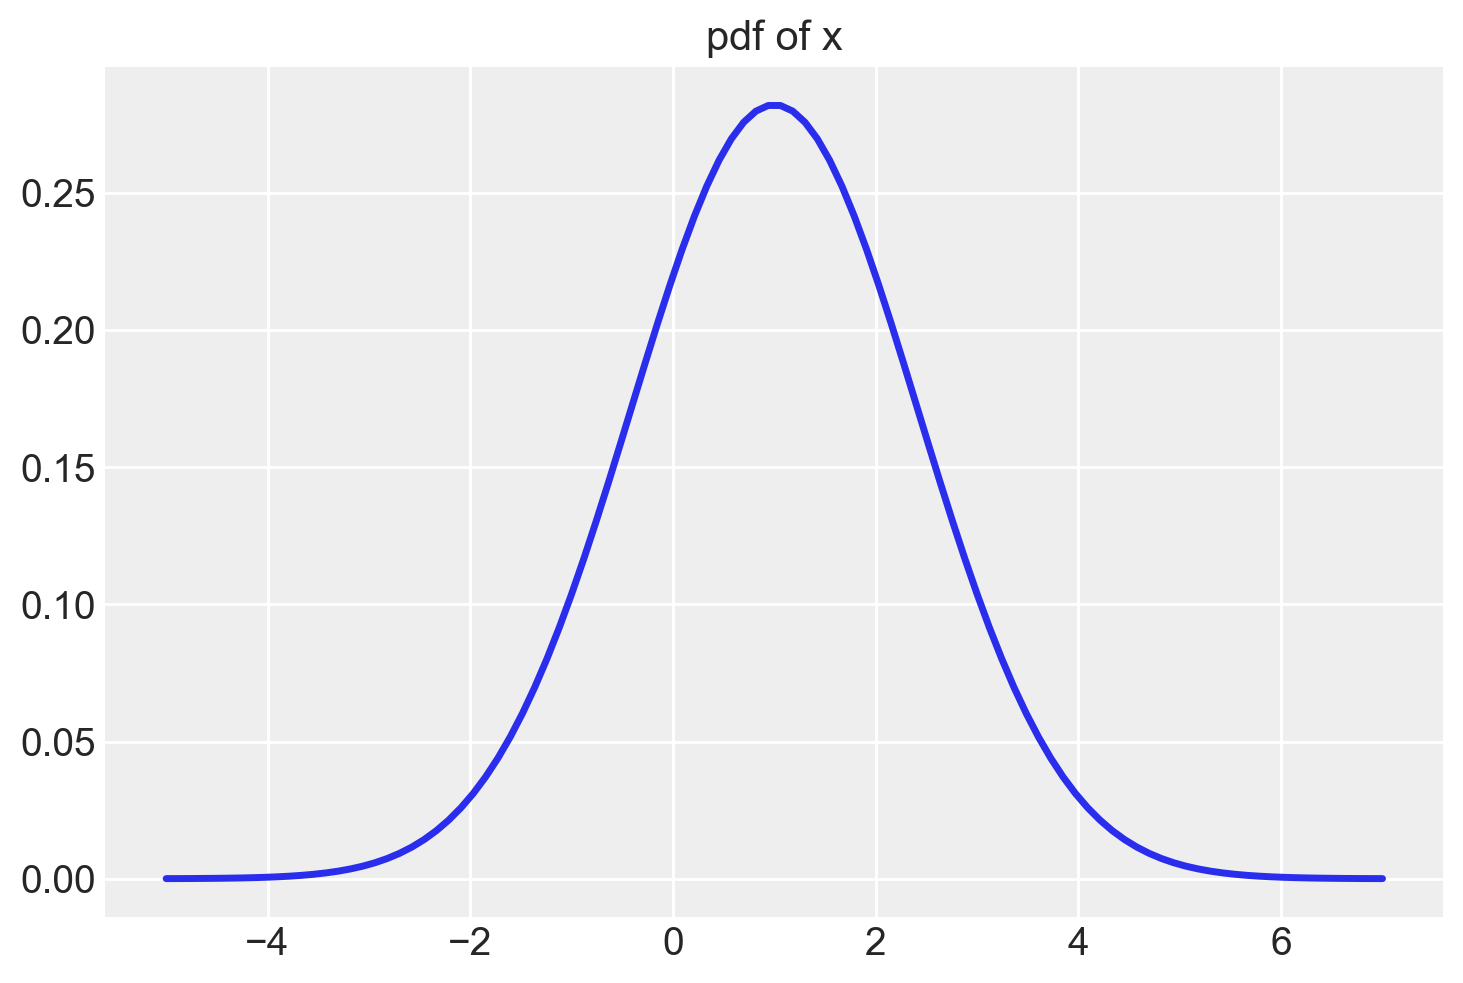

In [6]:
model = pm.Model()
with model:
    x = pm.Normal(name='x', mu=1., sigma=np.sqrt(2.))

xs = np.linspace(-5, 7, 100)
logpdfs = model.x.distribution.logp(xs).eval() # note the .eval() ; 
                                               #it converts a theano tensor 
                                               #into a numpy array 
    
plt.plot(xs, np.exp(logpdfs), linewidth=2.5)
_=plt.title('pdf of x', fontsize=15)

In [7]:
xsamples = 1 + np.sqrt(2.)*np.random.randn(50)  # generate 50 iid samples 
total_logprob = model.x.distribution.logp_sum(xsamples).eval()
print('The total log probability of all the samples is %.5f.'%total_logprob)

The total log probability of all the samples is -86.68717.


Note that all model specification in `PyMC3` must happen within the `pymc3.Model` context manager.

If this approach for computing the log probability feels complicated, do not worry - we will rarely (if ever) have to perform log probability explicitly when setting up inference models in `PyMC3` - the inference algorithms perform these computations under the hood for us.

### Setting up a joint model -  the `pymc3.Model` context 

To reiterate a previous point, `PyMC3.Model` context serves as a wrapper for the entire probabilistic model in `PyMC3`. Let's re-visit a simple problem - the coin toss example, and demonstrate how to setup a probabilistic model in `PyMC3`. 

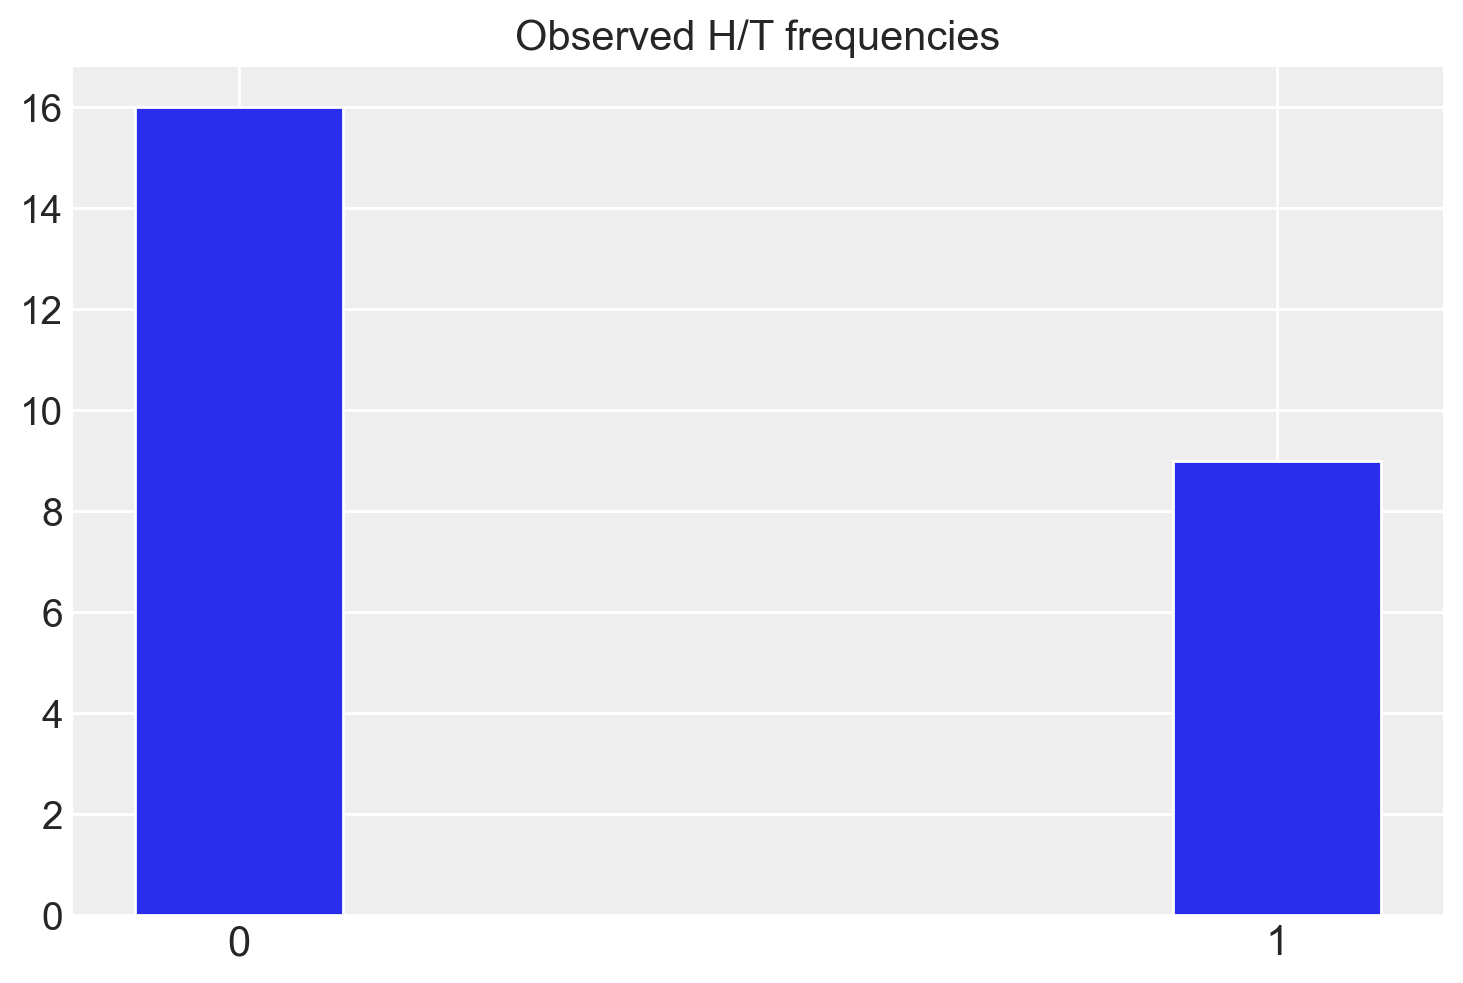

In [8]:
# data 
ptrue = 0.3  # prob of heads 
N = 25
data = np.random.binomial(1, ptrue, size=(N,))

# plot data 
_=plt.bar(*np.unique(data, return_counts=True), width=0.2)
_=plt.xticks([0, 1], fontsize=15)
_=plt.title('Observed H/T frequencies', fontsize = 15)

#### The coin toss model 

We observe data on repeated flipping of a coin with unknown probability of heads. 

Suppose the true probability of heads is $\theta$.

We do not know what $\theta$ really is, but we know it is somewhere in the interal $(0, 1)$. Let's be as vague about this as possible and assign equal probability density to all values in that interval, i.e., the prior is:
$$
\theta \sim \mathrm{Unif}([0, 1]).
$$

Each coin flip has a binary outcome - 1 (heads) or 0 (tails) and we can safely assume that each individual coin flip is independent of each other. 
Thus our likelihood model is:
$$
x_i|\theta \overset{\mathrm{i.i.d.}}{\sim} \mathrm{Bernoulli}(\theta).
$$

"Specifying" a probability model in a PPL means setting up a function for the joint distribution of latent and observed quantities - in this case,$p(\theta, \mathbf{x})$, where $\theta$ and $\mathbf{x} = (x_1, x_2, \dots, x_N)^T$. 
Here's the graphical description of this model:

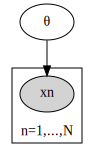

In [9]:
from graphviz import Digraph
gcp = Digraph('coin_toss_bayes_plate')
gcp.node('theta', label='<&theta;>')
with gcp.subgraph(name='cluster_0') as sg:
    sg.node('xn', label='<x<sub>n</sub>>', style='filled')
    sg.attr(label='n=1,...,N')
    sg.attr(labelloc='b')
gcp.edge('theta', 'xn')
gcp

And here's the `PyMC3` description of the model:

In [10]:
# instantiate a model context 
model = pm.Model()
theta_transform = pm.transforms.Interval(0, 1)

with model:
    # set up the prior 
    theta = pm.Uniform(name='theta', lower=0., upper=1.)
    
    # set up the likelihood 
    x = pm.Bernoulli(name='x', p=theta, observed=data)

    
print("Coin flip probability model:")
model

Coin flip probability model:


### Model variables in `PyMC3`

All unobserved (or latent) variables in a `pymc3` model are wrapped up into the user defined `model` context and exposed through the `model.vars` list. These are the variables over which inference is performed. 

In [11]:
latent_vars = model.vars
print(latent_vars)

[theta_interval__ ~ TransformedDistribution]


The coin flip model has only 1 latent variable, $\theta$. Notice that the `model.vars` list does not contain `theta` directly. Instead it contains a variable with the name `theta_interval__`. This is because, by default, variables that have finite suppport are passed through a bijective transformation to create a new variable that has support over the entire real line. 

For instance, $\theta$ in the coin flip example has support over the interval $(0, 1)$. For a variable constrained to lie within such the interval $[a, b]$, `pymc3` applies the transformation $g(x) = \log \frac{x - a}{b - x}$ ([see here](https://github.com/pymc-devs/pymc3/blob/683faaa9d7e58701f0689b1a1fd4080151f7e057/pymc3/distributions/transforms.py#L262)). 
The user-defined `model` context then adds the random variable $g(\theta)$ (rather than $\theta$ itself) to the `model.vars` list. 
In `PyMC3`, $g(\theta)$ is an instance of the `FreeRV` random variable class, i.e., it is a random variable that has support over entire $\mathbb{R}$. 
This automatic transformation is applied to make MCMC inference more efficient.

### Maximum a posteriori estimation using `pymc3.find_map`

Once you have set up the model, you need one extra line to perform any kind of inference. The `pymc3.find_map` does exactly what the name suggests - it finds a point estimate of the latent variables by maximizing the joint probability model.

In [12]:
init_val = {'theta':0.5}  # starting point for optimization
res = pm.find_MAP(model=model, start=init_val, progressbar=True)

In [13]:
theta_MAP = res['theta']
print('True p(H): %.2f ; Estimated p(H): %.2f'%(ptrue, theta_MAP))

True p(H): 0.30 ; Estimated p(H): 0.36


### Inference using `pymc3.sample`

Fully Bayesian inference is handled through the `pymc3.sample` interface, regardless of the inference technique, be it MCMC or VI.  
Let's infer the posterior over $\theta$ for this coin flip example. 

Note that you need to place the pm.sample within the context of the appropriate model.

In [14]:
with model:
    mcmc_res = pm.sample(draws = 10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 7 seconds.


You can then use `pymc3.traceplot` for visualizing the estimated posterior over the latent variables. 

/var/folders/5y/28n32xmx0551k29hd21qs87c0000gp/T/ipykernel_43016/1253366183.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(mcmc_res);
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


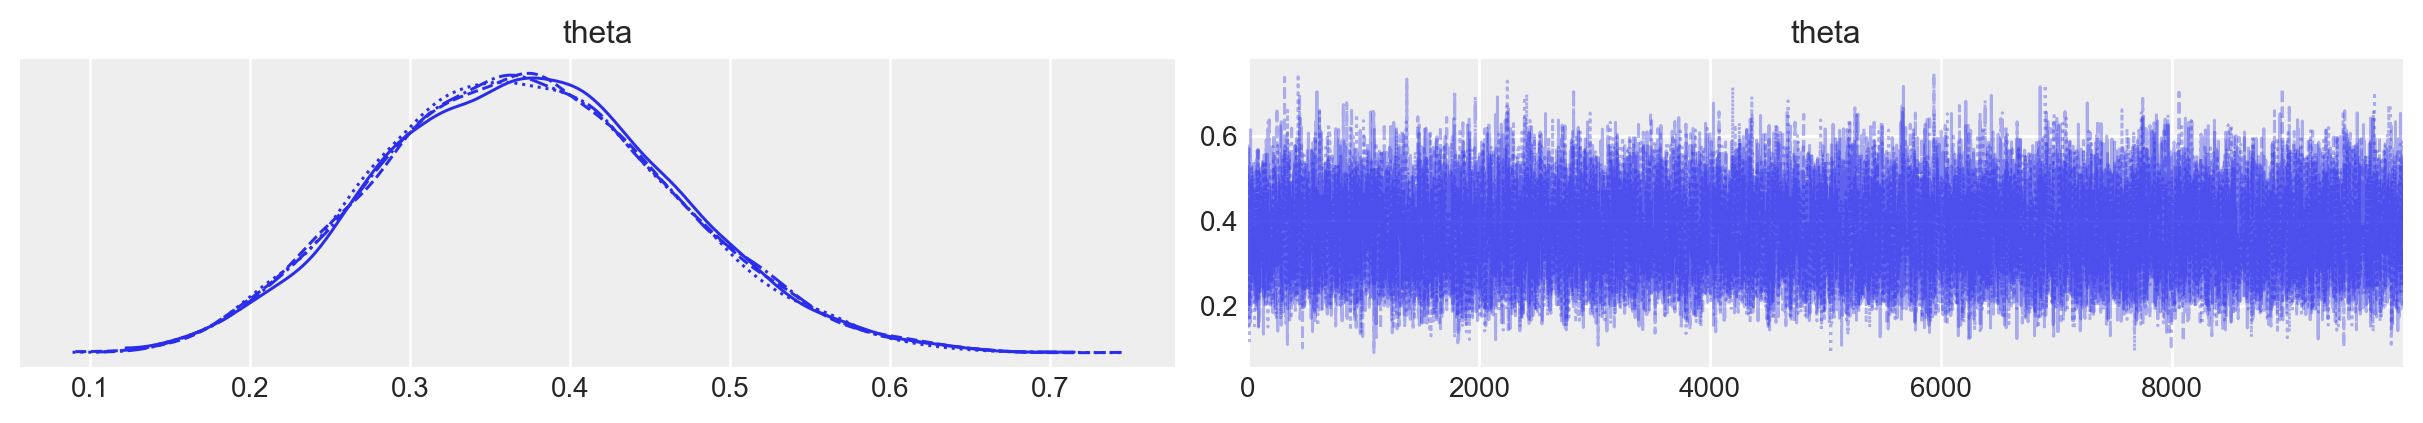

In [15]:
pm.traceplot(mcmc_res);

You can get a quantitative summary of the posterior as a `pandas.DataFrame` object using `pymc3.summary`:

In [16]:
summary = pm.summary(mcmc_res)
summary

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.372,0.092,0.202,0.543,0.001,0.0,16793.0,26909.0,1.0


In [17]:
np.percentile(mcmc_res.theta, [2.5, 50, 97.5])

array([0.202, 0.37 , 0.559])

You can access the generated MCMC samples for any latent variable through the `mcmc_res` object. See for example:

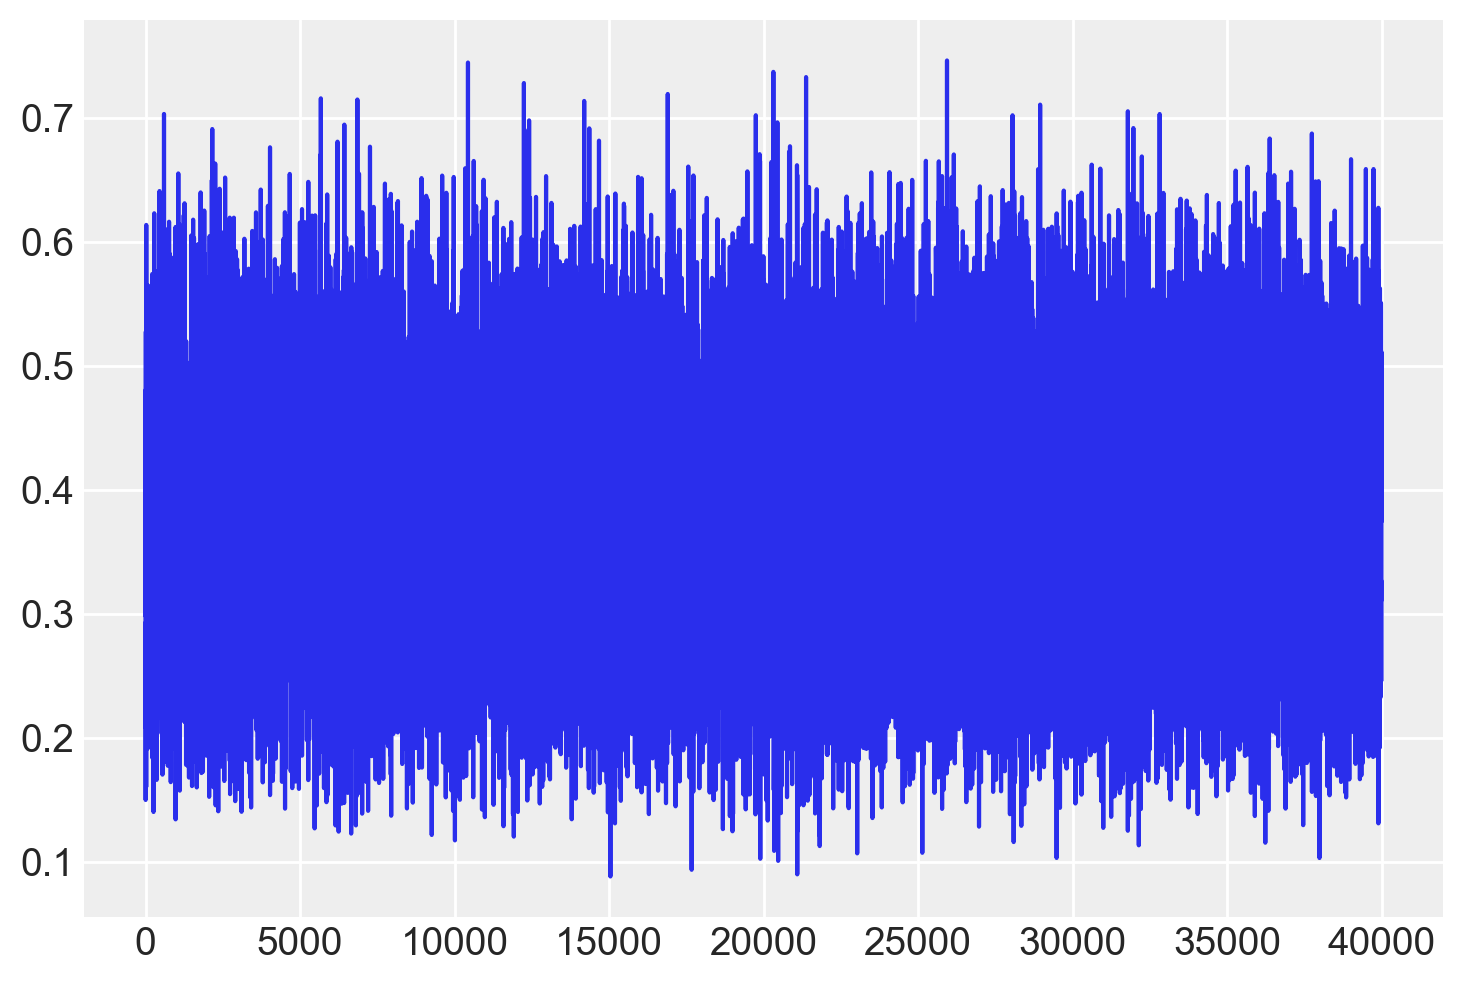

In [18]:
theta_mcmc_samples = mcmc_res.theta
plt.plot(theta_mcmc_samples);

### Visualization utilities 

`PyMC3` has numerous utility functions for generating various standard visualizations after performing inference. We demonstrate a few common ones here. 

#### Plotting the posterior of the latent variables 

Got error No model on context stack. trying to find log_likelihood in translation.


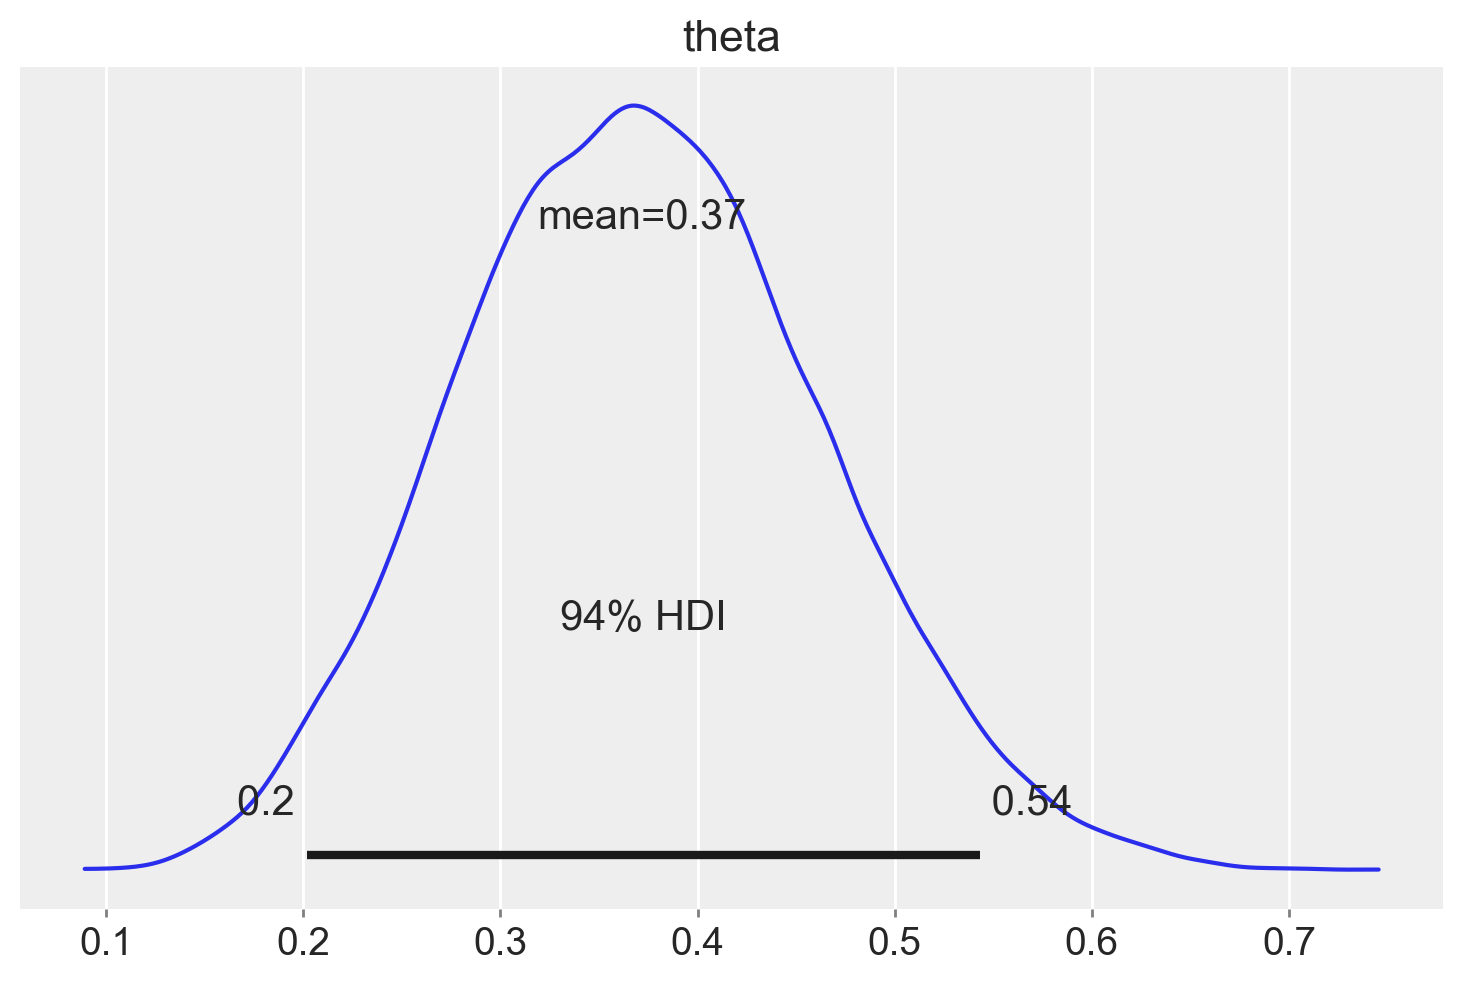

In [19]:
_=pm.plot_posterior(mcmc_res)   # just pass the mcmc trace to pm.plot_posterior

### Posterior predictive distribution

You can generate samples from the posterior predictive distribution, using the `pymc3.sample_posterior_predictive` functionality (see below).

In [20]:
pp_samples = pm.sample_posterior_predictive(trace=mcmc_res, samples=500, model=model)
x_post = pp_samples['x']
x_post.shape # num samples of theta \times size of the dataset 

/opt/homebrew/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


(500, 25)

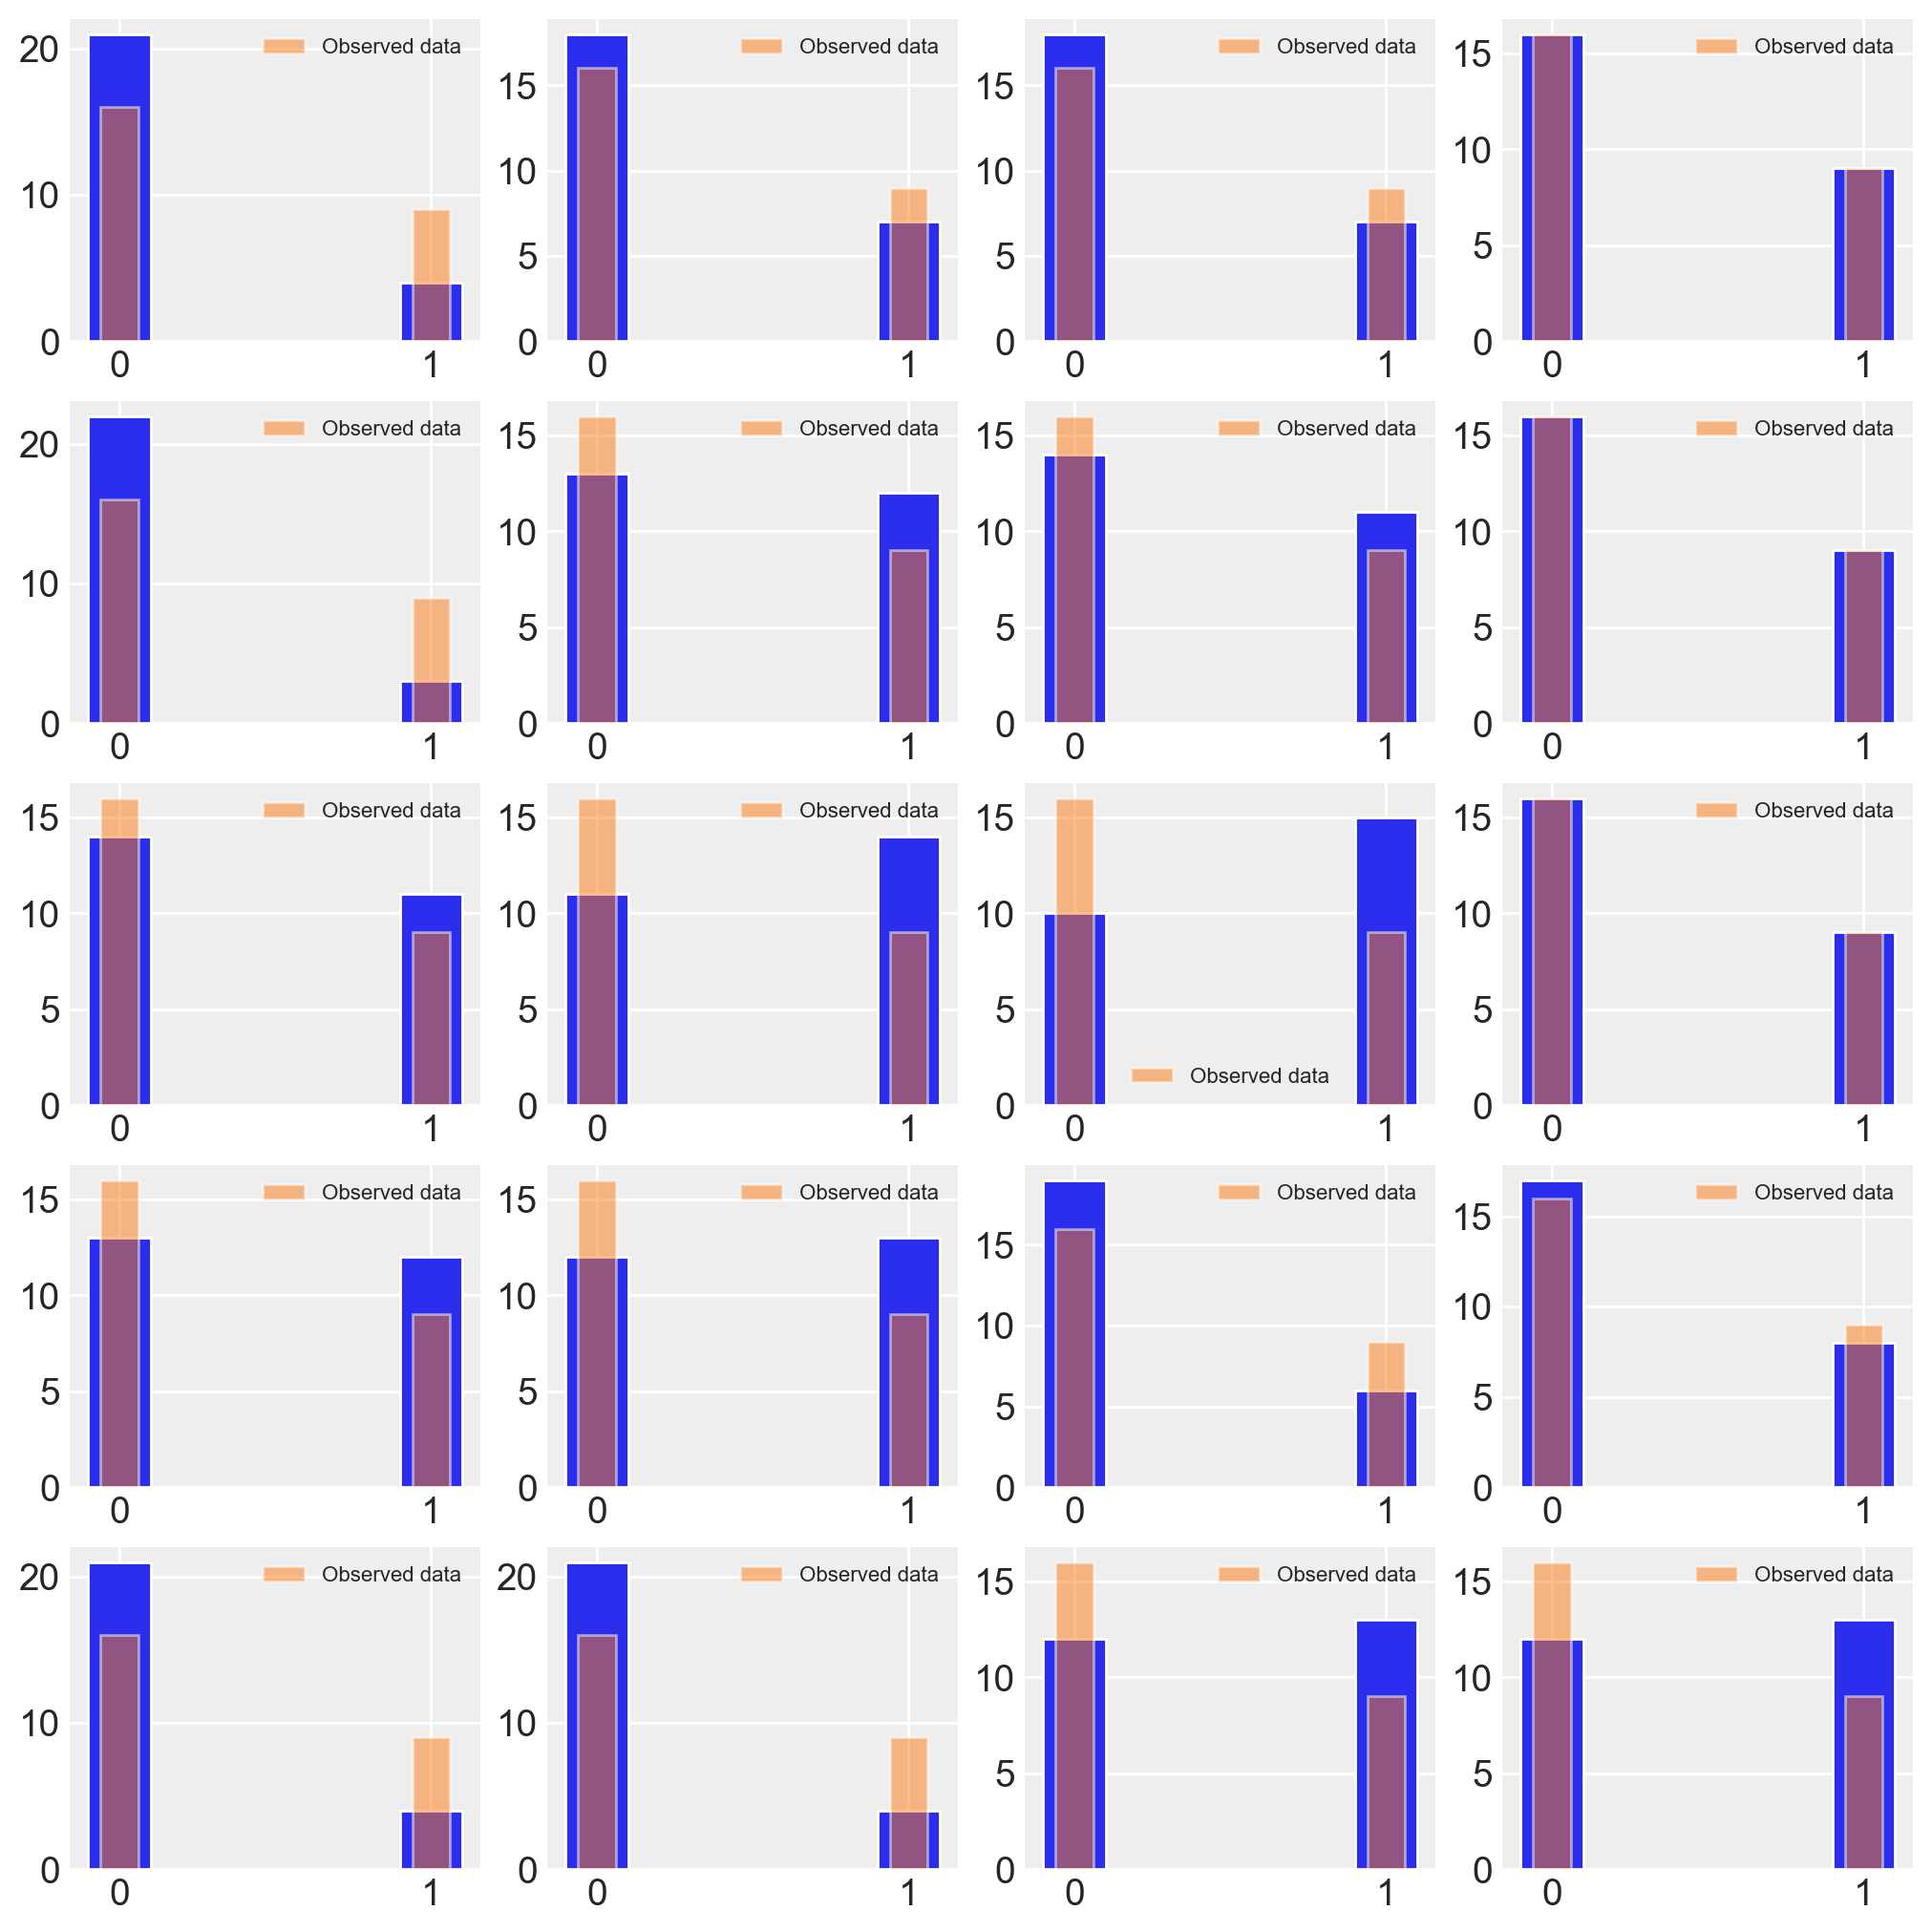

In [21]:
plt.figure( figsize=(10, 10) )
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.bar(*np.unique(x_post[i], return_counts=True), width=0.2)
    plt.bar(*np.unique(data, return_counts=True), width=0.12, 
            alpha=0.5, label='Observed data')
    plt.xticks([0, 1])
    plt.legend(loc='best', fontsize=8)

### Questions

- Rerun the example with a larger number of observations and observe that the posterior collapses to the right probability.